# PhIP-Seq Python analysis

Here, we are going to start by replicating the analysis done in `PhiP_seq_analysis_CIS.Rmd`, in python. This analysis can also be thought of as our "getting to know the data" stage of any good experiment.

The primary data is a counts 2-D array where the columns are the the samples (from which serum antibodies were used for the respective immunoprecipitation run), and the rows are enrichments from different peptides that were sequenced after immunoprecipitation of each sample serum. After replicating the R standardized enrichment, we will then take a look at some results, and finally discuss code structure for generating large scale, reproducible, and production quality results.

## Load Data

This is a good point of discussion - but moving forward I imagine we might have an easier time splitting the data from experiments into three tables: The counts table, the peptide metadata, and sample metadata. Because it's pretty trivial, I'm going to do it for this analysis to test it out. The three files generated should have been slack'd in `empirical_data.tar.gz`. This will be discussed more below in section `A simple(ish) data/analysis Python architecture`

In [1]:
import pandas as pd
import numpy as np
import argparse
import scipy.stats as st
import re
import sys
import os
import copy
from matplotlib import pyplot as plt
%matplotlib inline


# Set some constants
DD = "../empirical_data"
COUNTS = "sample_peptide_counts.csv"
PMETA= "peptide_metadata.csv"
SMETA= "sample_metadata.csv"
OUTDIR="./fold_analysis_output"

# the following two could (and should) be extracted from sample metadata
# once we determine a standardized format.
# Beads only sample is the mock IP
beads_only_sample = "35"

# The library_control is the pure abundance of phage in library sample
library_control_sample = "37"

# The (b pearson) correlation threshold which technical replicates must have
# before throwing out the sample
corr_thresh = 0.856

out_dir = os.path.join(DD,OUTDIR)
raw_counts = os.path.join(DD,COUNTS)
peptide_metadata = os.path.join(DD,PMETA)
sample_metadata = os.path.join(DD,SMETA)
# TODO extract this from sample metadata.

if not os.path.exists(out_dir): os.mkdir(out_dir) 

# TODO just make a function which returns all raw_counts and metadata 
# after error checking the input
raw_counts = pd.read_csv(raw_counts, header=0, index_col=0)
peptide_metadata = pd.read_csv(peptide_metadata, header=0, index_col=0)
sample_metadata = pd.read_csv(sample_metadata, header=0, index_col=0)
sample_metadata.index = sample_metadata.index.astype(str)

print(f"Raw counts DataFrame: \n\n {raw_counts.head()} \n\n")
print(f"Peptide metadata DataFrame: \n\n {peptide_metadata.head()} \n\n")
print(f"Sample metadata DataFrame: \n\n{sample_metadata.head()} \n\n")

Raw counts DataFrame: 

       1.1  1.2  10.1  10.2  11.1  11.2  12.1  12.2  13.1  13.2  ...  5.1  5.2  \
id                                                              ...             
1     102   12    61    74     7   132     4   380    79    51  ...   19  337   
10    106  229   183   352    81   777     0   122   310   112  ...  498  598   
195   106  229   183   352    81   777     0   122   310   112  ...  498  598   
100    54   63    73    15     8    97     6   213    60    94  ...   38    8   
1001    0    0    10    75     0     9     0     0     0     0  ...    2    0   

      6.1  6.2  7.1  7.2  8.1  8.2  9.1  9.2  
id                                            
1      53   13  210  484   70   77  189  484  
10     24  103  232  128   71  206  128  312  
195    24  103  232  128   71  206  128  312  
100    12   94   55  287   55   83  113  198  
1001    1    2   22    8    3    7    4   12  

[5 rows x 73 columns] 


Peptide metadata DataFrame: 

                  Viru

## Pruning counts with low reproducibility

In our PhiP seq, we are doing two technical replicates for each sample.
here, we drop all samples with low correlations (bpearson) between
those two samples, add the technical replicates we are keeping, and add 10 to every count in the dataframe.

In [2]:
# Make sure we have the same indexing going on here.
# Indexing will help query the three DF easily. 
assert(np.all(raw_counts.index == peptide_metadata.index))

# Now we need to look at correlation between the technical replicates,
# first determine the replicates.

# TODO there's certainly a cleaner way to do this.
technical_rep_1 = [re.match("\d+\.[1]",f"{sample_rep}")[0] 
for sample_rep in raw_counts.columns 
    if re.match("\d+\.[1]",f"{sample_rep}") != None]

technical_rep_2 = [re.match("\d+\.[2]",f"{sample_rep}")[0] 
for sample_rep in raw_counts.columns 
    if re.match("\d+\.[2]",f"{sample_rep}") != None]

print(f"Technical replicates 1:\n\n{technical_rep_1}\n\n")
print(f"Technical replicates 2:\n\n{technical_rep_2}\n\n")

pruned_counts = raw_counts.copy()
correlations, samples = [], []
for i, (t1, t2) in enumerate(zip(technical_rep_1, technical_rep_2)):
        
    # let's make sure we're looking at the same sample
    assert(t1.split(".")[0] == t2.split(".")[0])
    sample = t1.split(".")[0]

    # Now, lets determine which samples to drop,
    # and which samples we can sum replicates over
    # based off of correlation.
    corr = st.pearsonr(pruned_counts[t1], pruned_counts[t2])
    correlations.append(corr)
    samples.append(sample)
            
    # if the technical replicates are correlated enough then
    # sum the pruned_counts, add 10, and insert new column.
    #print(f"sample {sample} has technical rep correlation: {corr[0]} \
    #    with a p-value of {round(corr[1],5)}")
    if (corr[0] > corr_thresh and corr[1] <= 0.5):
        pruned_counts[sample] = pruned_counts[t1] + pruned_counts[t2] + 20
    else:
        print(f"dropping sample {sample}, b/c corr was: {corr[0]}")
        
        # would we expect the beads only sample to be correlated? I assume as much 
        # as any other sample? maybe not because the beads capture the phage clones
        # more randomly?
        if sample == beads_only_sample:
            print(f"warning, technical replicates for mock IP sample, {sample}, has a correlation of {corr[0]}")
            pruned_counts[sample] = pruned_counts[t1] + pruned_counts[t2] + 20

    pruned_counts.drop([t1,t2], axis=1, inplace=True)
    
pruned_counts[library_control_sample] = pruned_counts[library_control_sample] + 10

Technical replicates 1:

['1.1', '10.1', '11.1', '12.1', '13.1', '14.1', '15.1', '16.1', '17.1', '18.1', '19.1', '2.1', '20.1', '21.1', '22.1', '23.1', '24.1', '25.1', '26.1', '27.1', '28.1', '29.1', '3.1', '30.1', '31.1', '32.1', '33.1', '34.1', '35.1', '36.1', '4.1', '5.1', '6.1', '7.1', '8.1', '9.1']


Technical replicates 2:

['1.2', '10.2', '11.2', '12.2', '13.2', '14.2', '15.2', '16.2', '17.2', '18.2', '19.2', '2.2', '20.2', '21.2', '22.2', '23.2', '24.2', '25.2', '26.2', '27.2', '28.2', '29.2', '3.2', '30.2', '31.2', '32.2', '33.2', '34.2', '35.2', '36.2', '4.2', '5.2', '6.2', '7.2', '8.2', '9.2']


dropping sample 12, b/c corr was: 0.850798384205189
dropping sample 15, b/c corr was: 0.6109882519924675
dropping sample 28, b/c corr was: 0.31642563112379596
dropping sample 35, b/c corr was: 0.43714820853345443
warning, technical replicates for mock IP sample, 35, has a correlation of 0.43714820853345443


## Question: 

would we expect the beads only sample to be correlated? I assume as much as any other sample? maybe not because the beads capture the phage clones more randomly?

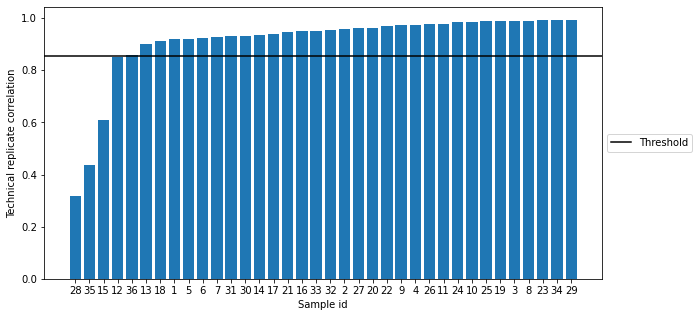

In [3]:
# and plot the correlation to sanity check indexing.

fig, ax = plt.subplots(figsize=(13, 10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

correlations = [c[0] for c in correlations]
samples = [x for _,x in sorted(zip(correlations,samples))]
ax.bar(samples, sorted(correlations))
ax.axhline(y=corr_thresh, color="black", label = "Threshold")
ax.set_ylabel(f"Technical replicate correlation")
ax.set_xlabel(f"Sample id")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10,5)
#fig.savefig(os.path.join(out_dir,"technical_replicates_correlation.pdf"))
plt.show()

Correlations agree with R.

## Python standardized enrichment (computation)

Next, we take our pruned counts, and get standized enrichments by; (1) computing the sample frequencies (divide each column by its repective sum) (2) compute peptide enrichment by normalizing each row by the library control sample, essentially putting each frequency in terms of the total amount of phage present in the library (3) finally, we subtract the mock IP (negative control) enrichment from each respective row - giving us _standardized enrichment_

In [4]:
frequencies = pruned_counts.truediv(pruned_counts.sum(axis=0), axis=1)
enrichment = frequencies.truediv(frequencies[library_control_sample], axis=0)
standardized_enrichment = enrichment.subtract(enrichment[beads_only_sample], axis=0)

## R standardized enrichment (comparison w/ Python)

Below, I'm going to load in the exact file created by computing standardized enrichment in R. I will then do a few things to normalize the indexing and column order of both Dataframes, and run a comparison test.

In [5]:
r_standardized_enrichment = pd.read_csv(
    "../empirical_data/20200325_standardized_enrichment_summed_reps.csv",
    header = 0,
    index_col = 1).drop(['Unnamed: 0', 'Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence'],
                       axis = 1)

r_standardized_enrichment = r_standardized_enrichment.astype("float64")
aligned_column_names = {x : x[1:] for x in r_standardized_enrichment.columns}
aligned_column_names["X37.input"] = "37"
r_standardized_enrichment.rename(aligned_column_names, axis=1, inplace =True)

samp1_p = standardized_enrichment["1"]
samp1_r = r_standardized_enrichment["1"]

print(f"First five enrichments of sample 1 Python Standardized enrichment : \
\n\n{samp1_p.head()}\n\nFirst five enrichments of sample 1 R Standardized \
enrichment : \n\n{samp1_r.head()}\n\n")

assert(standardized_enrichment.shape == r_standardized_enrichment.shape)
assert(np.all(set(standardized_enrichment.columns) == set(r_standardized_enrichment.columns)))
assert(np.all(standardized_enrichment.index == r_standardized_enrichment.index))

# make the column order the same for both
r_standardized_enrichment = r_standardized_enrichment[standardized_enrichment.columns]

# Test that we have the same enrichments 
pd.testing.assert_frame_equal(standardized_enrichment, r_standardized_enrichment) 
print("\nSuccessfully re-created R fold enrichment")

First five enrichments of sample 1 Python Standardized enrichment : 

id
1       0.251551
10      0.138677
195     0.138677
100    -1.679056
1001   -0.293720
Name: 1, dtype: float64

First five enrichments of sample 1 R Standardized enrichment : 

id
1       0.251551
10      0.138677
195     0.138677
100    -1.679056
1001   -0.293720
Name: 1, dtype: float64



Successfully re-created R fold enrichment


## Python Results. 

Looks like we get a few interesting (looking) results! First we choose some samples, and specific virus strains we would like to see enrichment for - as a function of tile rank ("genomic location"). The following list represents the list of all possible virus strains and samples

In [6]:
! cat ../empirical_data/peptide_metadata.csv | cut -d ',' -f 2 | sort | uniq | sort | grep -v -e "Virus_Strain"

CHIKV_KPA15_NS
CHIKV_KPA15_S
CHIKV_TR206-H804187_NS
CHIKV_TR206-H804187_S
DENV1_Myanmar1996
DENV1_WesternPacific
DENV2_16803
DENV2_BR-BID-V3653-2008
DENV2_BurkinaFaso1983
DENV2_NewGuineaC
DENV3_BR-BID-V2403-2008
DENV3_Mozambique1985
DENV4_H781363
DENV4_P73_1120
DENV4_SJRP-850-2013
HIV_Env_BF520_W14_C2
HIV_Env_BG505_W6_C2
HIV_Env_CladeA1
HIV_Env_CladeA2
HIV_Env_CladeB
HIV_Env_CladeC
HIV_Env_CladeD
HIV_Env_Q23
HIV_Env_Q461_d1
HIV_Env_QA013_385M_ENV_R3
HIV_Env_QA013_70I_ENV_H1
HIV_Env_QB850_632p_B10
HIV_Env_QB850_72p_C14_A1
HIV_Env_QC406_F3
HIV_Gag_CladeA1
HIV_Gag_CladeA2
HIV_Gag_CladeB
HIV_Gag_CladeC
HIV_Gag_CladeD
HIV_Gag_Q23
HIV_Nef_CladeA
HIV_Nef_CladeB
HIV_Nef_CladeC
HIV_Nef_CladeD
HIV_Nef_Q23
HIV_Pol_CladeA1
HIV_Pol_CladeA2
HIV_Pol_CladeB
HIV_Pol_CladeC
HIV_Pol_CladeD
HIV_Pol_Q23
HIV_Rev_CladeA1
HIV_Rev_CladeA2
HIV_Rev_CladeB
HIV_Rev_CladeC
HIV_Rev_CladeD
HIV_Rev_Q23
HIV_Tat_CladeA1
HIV_Tat_CladeA2
HIV_Tat_CladeB
HIV_Tat_CladeC
HIV_Tat_CladeD
HIV_Tat_Q23
HIV_Vif_CladeA
HIV_Vif_Clade

Now we select analysis to run, and query our data. Here, we want to isolate the indices for the _virus strain_ of interest, and plot those tiles and their respective standardized enrichment for an individual. These are all plotted as a funtion of tile position across the respective viral genome. Hopefully, we might see cross-reactivity between some strains for a sample of interest (similar bumps on the lines, I suppose). 

In [7]:

# choose a "pattern for virus strain" to compare.

strain_pattern = "HIV.+"
#strain_pattern = "HIV_Gag.+"
#strain_pattern = "DENV.+"
#strain_pattern = "ZIKV.+"

all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

# or choose some strains explicitly

#selected_strains = ["ZIKV_HPF2013", "ZIKV_PRVABC59"]
#selected_strains = ["HIV_Env_BF520_W14_C2", "HIV_Env_BG505_W6_C2"]

# choose some samples

# samples = ["11"]
#samples = standardized_enrichment.columns[1:]

# some samples with a positive control
samples = [str(x) for x in list(range(6,9))] + ["36"]

print(f"sample\tsample_info\tseroepi_paper_id\tnotes\n")
for sample in samples:
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    
    print(f"{sample}\t{sample_info}\t{seroepi_paper_id}\t{notes}")

print(f"\ncomparing virus strains:\n\n {selected_strains} \n\n ")



sample	sample_info	seroepi_paper_id	notes

6	16925_8.11.2006	M5	secondary DENV
7	11257_24.3.1994	M6	DENV-2
8	17093_4.10.2006	M7	secondary DENV
36	240-D_mAb	nan	positive control

comparing virus strains:

 ['HIV_Gag_Q23', 'HIV_Env_BG505_W6_C2', 'HIV_Rev_CladeB', 'HIV_Nef_CladeA', 'HIV_Gag_CladeA1', 'HIV_Vif_CladeA', 'HIV_vpu_CladeB', 'HIV_Tat_CladeD', 'HIV_vpu_CladeA', 'HIV_Vif_CladeB', 'HIV_vpr_CladeD', 'HIV_Tat_CladeA2', 'HIV_Env_CladeC', 'HIV_Rev_CladeA1', 'HIV_Vif_CladeD', 'HIV_vpu_CladeC', 'HIV_Nef_CladeB', 'HIV_vpr_CladeB', 'HIV_Tat_CladeB', 'HIV_Env_QC406_F3', 'HIV_vpu_CladeD', 'HIV_Vpu_Q23', 'HIV_Env_CladeD', 'HIV_Rev_CladeC', 'HIV_Gag_CladeC', 'HIV_Nef_CladeC', 'HIV_Rev_CladeA2', 'HIV_Env_CladeA1', 'HIV_Gag_CladeB', 'HIV_Gag_CladeA2', 'HIV_vpr_CladeC', 'HIV_Pol_Q23', 'HIV_Tat_Q23', 'HIV_Pol_CladeB', 'HIV_vpr_CladeA', 'HIV_Rev_Q23', 'HIV_Vpr_Q23', 'HIV_Env_Q461_d1', 'HIV_Tat_CladeA1', 'HIV_Nef_CladeD', 'HIV_Env_CladeA2', 'HIV_Env_Q23', 'HIV_Gag_CladeD', 'HIV_Pol_CladeA2', 'HIV_E

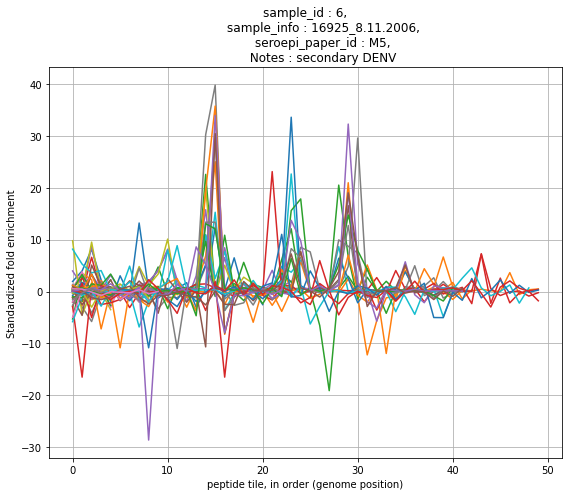

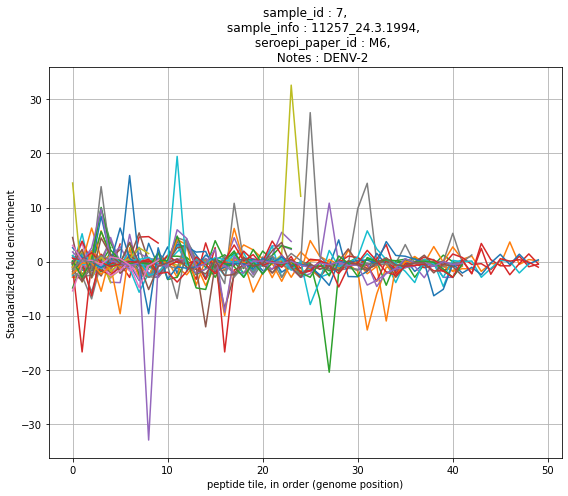

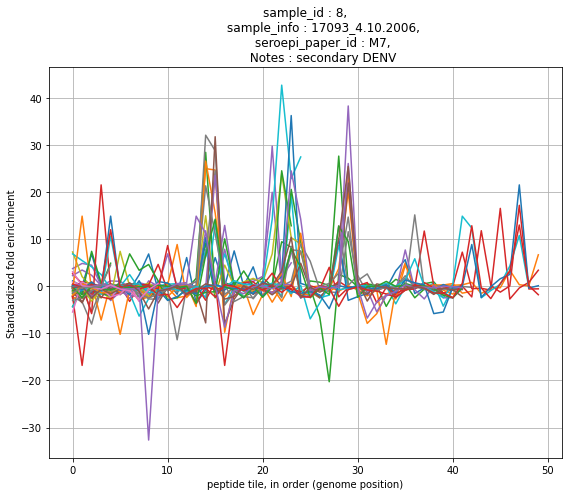

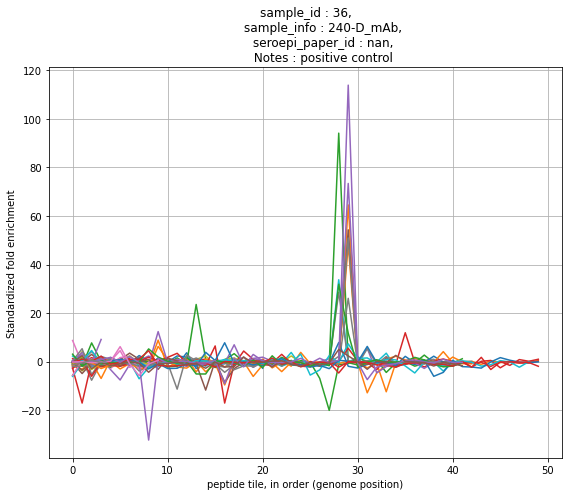

In [8]:

# make a seperate plot for each sample
for sample in samples:
    if sample == library_control_sample: continue
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    for strain in selected_strains:
        strain_indices = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax.plot(list(range(len(strain_indices))),
                standardized_enrichment[sample][strain_indices],
                label = strain)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax.set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(f"Standardized fold enrichment")
    ax.set_xlabel(f"peptide tile, in order (genome position)")
    ax.grid()
    plt.tight_layout()
    #fig.savefig(f"../Attic/fold_enrichment_{sample}.pdf")
    plt.show()


## Ambiguous peptide sequences.

I noticed that some strains, specifically for Zika, were _highly_ correlated. This is most likely due to _ambiguous peptide sequences_ which belong to multiple to virus strains. Notice, there is a slight offset and little correlations near the end. This is almost certainly something we should keep in mind.

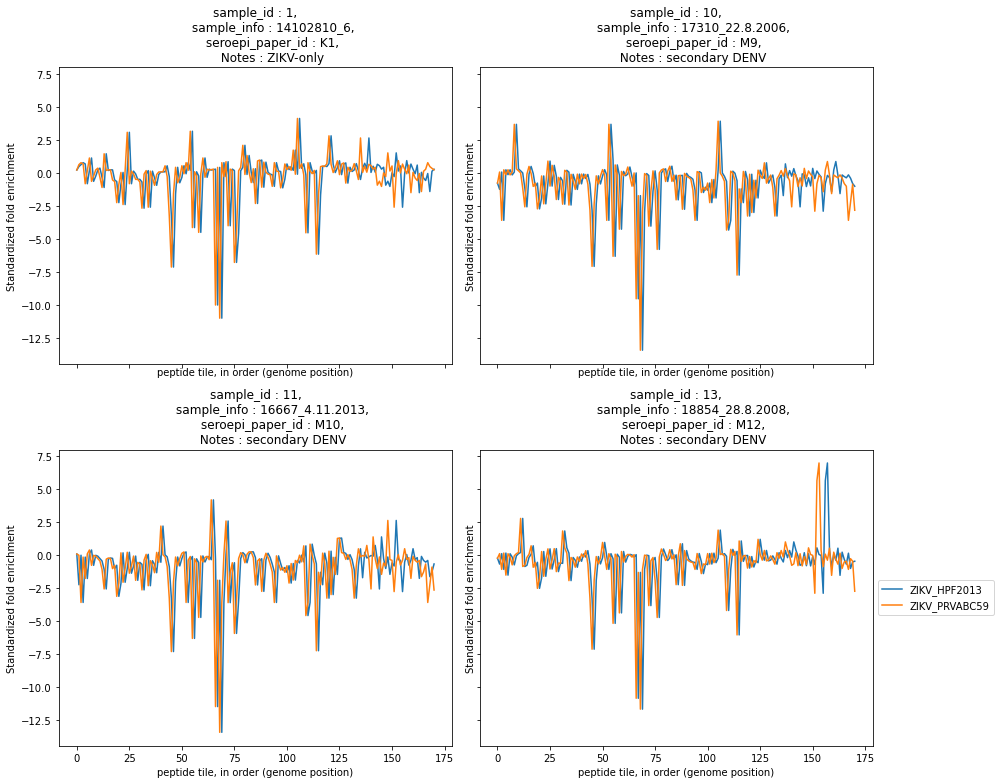

In [9]:

#strain_pattern = "HIV_Gag.+"
#strain_pattern = "DENV.+"
#strain_pattern = "ZIKV.+"

# samples to look at, this could also be done 
# by querying the sample metadata or listed manually
samples = standardized_enrichment.columns
all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

selected_strains = ["ZIKV_HPF2013", "ZIKV_PRVABC59"]
#selected_strains = ["HIV_Env_BF520_W14_C2", "HIV_Env_BG505_W6_C2"]

fig, ax = plt.subplots(2,2,figsize=(14, 11),sharex=True,sharey=True)
for i, sample in enumerate(samples[1:5]):
    if sample == library_control_sample: continue
    
    row = i // 2
    column = i % 2
    
    for strain in selected_strains:
        strain_index = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax[row][column].plot(list(range(len(strain_index))),
                            standardized_enrichment[sample][strain_index],
                            label = strain)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax[row][column].set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")

    ax[row][column].set_ylabel(f"Standardized fold enrichment")
    ax[row][column].set_xlabel(f"peptide tile, in order (genome position)")
ax[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
#fig.savefig(f"../Attic/fold_enrichment_1.pdf")


## A simple(ish) data/analysis Python architecture

It would be nice to put together a (tested and documented) mini python package to make doing more complex analysis quick and reliable. Below, we take a look at possible **input** and **data organization**

### 1. Input :

What input should our code begin from? There is a trade-off in terms of how raw vs. preprocessed the input data is. If the data is raw there is less margin for error involved in handling the files above and generally  

    option a. Raw data:
    
         * sample fasta files (demultiplexed?) 
         * peptide library from which to build an index? or just the pre-built index.
         * sample metadata (barcodes included if not demultiplexed)
         * NOTE: 
 
[Here](https://github.com/LarmanLab/PhIP-Seq-Analyzer/blob/master/bioTreatFASTQ.py) 
         is something similar done by the larman lab : 
         
    option b. raw aligned sample data (my favorite):
    
        * sam files for each of the samples
        * viral annotations (maybe this just comes in the form of peptide metadata)
        * sample metadata
        
    option c. counts data
    
        * counts matrix
        * peptide metadata
        * sample metadata
        
**IMO**:

If we start from scratch (option a) we are essentially reinventing the wheel by calling a bunch of `subprocesses` from `Python`. This would mean we would also need to parallel-ize the calls to each sample alignment and peptide counting _within_ python. Instead, if we use a pipeline manager, like `nextflow` or `snakemake`,  then these operations are already run in parallel when farmed out to a cluster. Alternatively, If we start with the counts data (option c), we're going to need _something_ to merge the counts and peptide data, so why not Python?

With option b, Our code would simply start by organizing/merging/error-handling all the counts  to create a normalized format (that can be exported, queried, or transformed). From there, we could create seperate scripts with rules to do multiple types of analysis, from the _same_ data. This is visualized below.

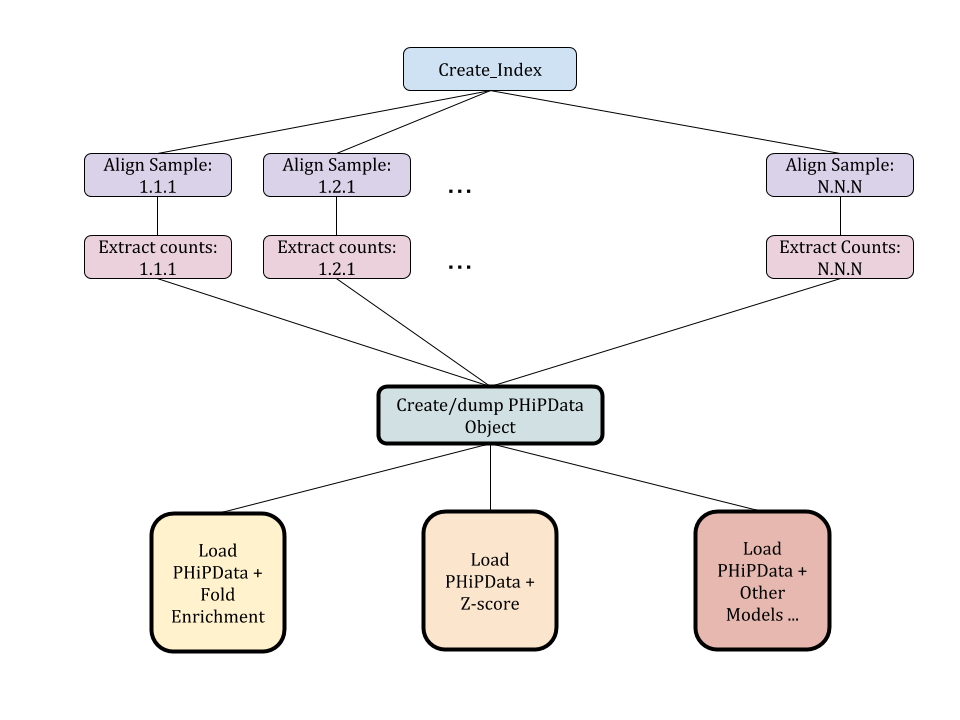

### 2. Data organization

The primary data is counts data - yet each sample/peptide have metadata which is useful to know for obtaining interesting subsets of specific enrichments associated with _virus strains, peptide types, sample types, etc_. This is why using uniform indexing of three seperate tables seemed like a reasonably intuitive option for dealing with the data.

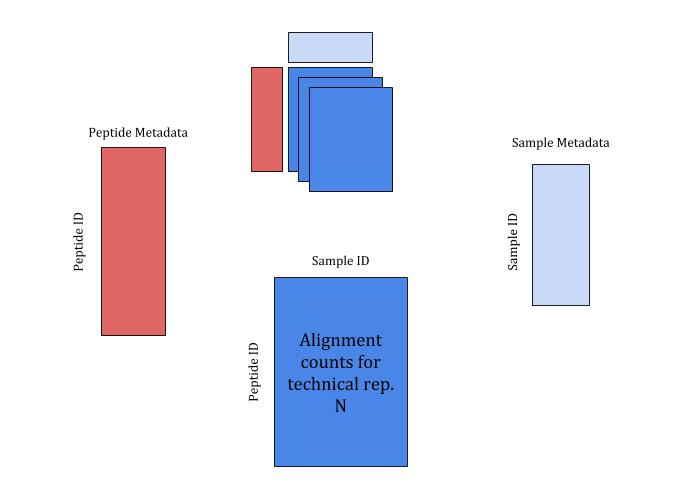

In [10]:

# TODO
class PhipData(object):
    """
    A class to organize, query, and transform 
    PhIP-seq data.
    """
    def __init__(self,
                counts_tables,     # 3D array-like
                peptide_metadata,  # 2D array-like
                sample_metadata):  # 2D array-like
        
        # 1. Do some basic input format checking
        self._assert_data_consistancy(counts_tables, peptide_metadata, sample_metadata)
        
        # 2. Infer Mock IP's and library control 
        
        # 3. ????
        
        
        pass
    
    def _assert_data_consistancy(self, counts, sample_md, peptide_md):
        """
        'private' method to do some sanity checking and error handling
        on the inputs provided. This will provide some 
        useful warning error messages, as well as provide a platform for
        testing that the input will be valid for all methods below.
        """
        pass
    
    
    def dump(self, output_path):
        """
        (possibly) Organize the three tables into a dictionary-like structure 
        Use pickle/numpy/pandas to dump all the data 
        and make it easy to unpack and load again into the same object. 
        """
        pass
    
    
    def technical_replicate_correlations(self):
        """
        compute and return all correlations between 
        available technical replicates.
        """
        pass
        

    def get_mock_ip(self):
        """
        """
        pass
    
    
    def get_library_control(self):
        """
        """
        pass
    
    
    def etc(self):
        """
        """
        pass

## Discussion points or questions?